Modeling and testing grounds

In [15]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.models import load_model

from numpy.random import seed
from tensorflow import set_random_seed

from skimage.transform import resize

import datetime
from tqdm import tqdm_notebook
import pickle

In [3]:
seed(42)
set_random_seed(42)

# Modeling and Evaluation Functions

Writing multiple functions to facilitate creating different datasets, modeling over different datasets and/or different hyperparameters, and evaluating the different models using graphs




In [4]:
class PnemoniaTargetMapIsWeird(AssertionError):
    """Raise this when the target is not mapped to 2 or 3 outputs"""
    pass

In [5]:
def create_pic_df(data, df_detailed, image_size = (128,128)):
    
    print('---Enter DataFrame Construction Function---')
    
    ## Data Prep
    # Need to define df_detailed somewhere
    data.drop_duplicates(inplace=True)
    merged_df = df_detailed.merge(data, on='patientId')
    
    print('---Create Pixel Array Labels---')
    
    # Create the column labels for the pixel arrays
    pixel_labels = []
    for i in range(image_size[0] * image_size[1]):
        pixel_labels.append("pixel"+str(i))
    
    print('---Create Total Pixel Array---')
    
    # Create the total pixel array
    huge_pixel_array = []
    for o in tqdm_notebook(range(merged_df.shape[0])):
        # Get the image data
        patientId = merged_df.iloc[o]['patientId']
        dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
        dcm_data = pydicom.read_file(dcm_file)
        im = dcm_data.pixel_array

        # Convert the image into a 1d array of pixels
        curr_pixel_array = []
        for i in resize(im, image_size): 
            curr_pixel_array.extend(i)
        huge_pixel_array.append(curr_pixel_array)

    print('---Create Dataframe---')
        
    # Creating the DataFrame
    temp = pd.DataFrame(data = huge_pixel_array, columns = pixel_labels)
    temp['class'] = merged_df['class']
    return temp

In [6]:
def model(data, model_name = "default_model_name", image_size = (128,128), y_map = {
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":2
}, EPOCHS = 20, train_size = 0.75, metrics = ['accuracy'] ):
    """
    Args:
        data (Pandas DataFrame): cols=['class', all of the pixel data]
        
        model_name (str): The name with which to save the model
        
        image_size (touple: (int,int)): The width and height in pixels to scale the images. Max 1024x1024. This might be more finickey that I would've thought.
        
        y_map (dict): A dictionary mapping the target values to integers (0-?)
        
    Returns:
        Keras Model fit on the data.
        Saves the model to ../data/models/model_name datetime.h5
    """
    print('---Enter Function---')
    

    # Create target
    y = data['class']
    y = y.map(lambda x: y_map[x])
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='class'), y, 
                                                        stratify=y, random_state=42, train_size = train_size)
    
    # Transform target into arrays of integers
    y_train_c = to_categorical(y_train)
    y_test_c = to_categorical(y_test)
    
    # Reshape the X_train and X_test 
    X_train_re = X_train.values.reshape(X_train.shape[0], image_size[0], image_size[1], 1)
    X_test_re = X_test.values.reshape(X_test.shape[0], image_size[0], image_size[1], 1)
    
    print('---Modeling---')
    
    ## Modeling
    # Initialize Model
    model_convolutional = Sequential()

    # First Conv / Pool 
    model_convolutional.add(Conv2D(filters = 6,
                                   kernel_size = 3,
                                   activation = 'relu',
                                   input_shape = (image_size[0], image_size[1], 1)
                                  ))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

    # Second Conv/ Pool
    model_convolutional.add(Conv2D(filters=16, kernel_size=3, 
                                   activation='relu'))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model_convolutional.add(Dropout(0.8))
    model_convolutional.add(Flatten())

    # Densely Connected Layers
    model_convolutional.add(Dense(512, activation='relu'))
    model_convolutional.add(Dropout(0.5))
    model_convolutional.add(Dense(128, activation='relu'))
    model_convolutional.add(Dropout(0.5))
    
    # Output Layer
    if len(set(y_map.values())) == 3:
        model_convolutional.add(Dense(3, activation='softmax'))
    elif len(set(y_map.values())) == 2:
        model_convolutional.add(Dense(2, activation='softmax'))
    else:
        raise PnemoniaTargetMapIsWeird("target is not mapped to 2 or 3 outputs")


    model_convolutional.compile(loss = 'categorical_crossentropy', 
                            optimizer = 'adam', 
                            metrics = metrics)
    
    # Train Model
    trained_convolutional = model_convolutional.fit(X_train_re,
                        y_train_c,
                        batch_size = 32,
                        epochs = EPOCHS,
                        verbose = 1,
                        validation_data = (X_test_re, y_test_c)
                       )

    # Save Model 
    try:
        file_name = '../data/models/' + model_name + ' ' + str(datetime.datetime.now()) + '.h5'
        
        model_convolutional.save(file_name)
        print('Model saved as: ' + file_name)
        
    except Exception as e:
        print('Model did not save.')
        print(e)
        
        
    return trained_convolutional, model_convolutional, file_name



In [32]:
# Function that displays pertinant information regarding the quality of the model

def evaluate_model (model, model_name = 'default', size=6):
    
    """
    Args:
        model: A trained model with 
        
    Output:
        Returns nothing. Prints out - plots comparing test set with training set on 
        each of the metrics (minimum: loss).
    
    """
    
    # checking out the different classes in the testing case and predictions
    
    # confusion matrix?
    
    keys=[]
    for i in model.history.keys():
        if i[0:3] != 'val':
            keys.append(i)
    
    fig, ax = plt.subplots(len(keys), 1, figsize = (size, size*len(keys))) 
    fig.suptitle('Model: ' + model_name[15:-3], fontsize=16)
    
    index = 0
    for i in keys:
        # Plot of the Loss for the train and testingsets
        ax[index].plot(model.history[i], label=i.capitalize())
        ax[index].plot(model.history['val_'+i], label='Val '+i.capitalize())
        ax[index].legend()
        ax[index].set_title(i.capitalize())
        index+=1


## Some initial modeling

In [8]:
# Lung Opacity == Pneumonia
y_map_3 = { # Normal, Pneumonia, or not normal but not pneumonia
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":2
}

y_map_2 = { # Either Pneumonia or Not Pneumonia
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":0
}

adult_data = pd.read_csv('../data/adult_patient_data.csv')
df_detailed = pd.read_csv('../data/stage_1_detailed_class_info.csv')


In [34]:
models = {}

In [35]:
# Current Parameters
options = 3


NUM_IMAGES = 6000 #pic_df.shape[0]
EPOCHS = 20
IMAGE_SIZE = (128,128)
TRAIN_SIZE = 0.8
METRICS = ['accuracy']

if options == 2:
    CURR_MAP = y_map_2
    model_name = 'adult_data_2_options'
elif options == 3:
    CURR_MAP = y_map_3
    model_name = 'adult_data_3_options'
else:
    raise PnemoniaTargetMapIsWeird('Set "option" to 2 or 3')


In [11]:
%%time

pic_df = create_pic_df(adult_data, df_detailed=df_detailed, image_size=IMAGE_SIZE)

---Enter DataFrame Construction Function---
---Create Pixel Array Labels---
---Create Total Pixel Array---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



---Create Dataframe---
CPU times: user 8min 33s, sys: 15 s, total: 8min 48s
Wall time: 8min 50s


In [36]:
%%time



test_model_history, test_model_real, most_recent_model_name = model(pic_df.head(NUM_IMAGES), model_name = model_name, image_size=IMAGE_SIZE, y_map=CURR_MAP, EPOCHS=EPOCHS, train_size = TRAIN_SIZE, metrics = METRICS)



---Enter Function---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


---Modeling---
Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 27s 6ms/step - loss: 0.9727 - acc: 0.5121 - val_loss: 0.8885 - val_acc: 0.5925
Epoch 2/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8916 - acc: 0.5648 - val_loss: 0.8520 - val_acc: 0.6017
Epoch 3/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8686 - acc: 0.5823 - val_loss: 0.8462 - val_acc: 0.5975
Epoch 4/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8549 - acc: 0.5958 - val_loss: 0.8598 - val_acc: 0.6042
Epoch 5/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8401 - acc: 0.6002 - val_loss: 0.8355 - val_acc: 0.6183
Epoch 6/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8034 - acc: 0.6202 - val_loss: 0.8302 - val_acc: 0.6108
Epoch 7/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8031 - acc: 0.6227 - val_loss: 0.8121 - val_acc:

In [91]:
models[most_recent_model_name] = {
    'NUM_IMAGES':NUM_IMAGES,
    'history':test_model_history,
    'EPOCHS':EPOCHS,
    'IMAGE_SIZE':IMAGE_SIZE,
    'Y_MAP':CURR_MAP,
    'TRAIN_SIZE':TRAIN_SIZE,
    'accuracy_scores':{
        'train':test_model_history.history['acc'][-1],
        'test':test_model_history.history['val_acc'][-1]
    }
}

# Save the list of models and parameters 
model_pickle_file_name = 'models.pk'
file_object = open(model_pickle_file_name,'wb')
pickle.dump(models, file_object)
file_object.close()


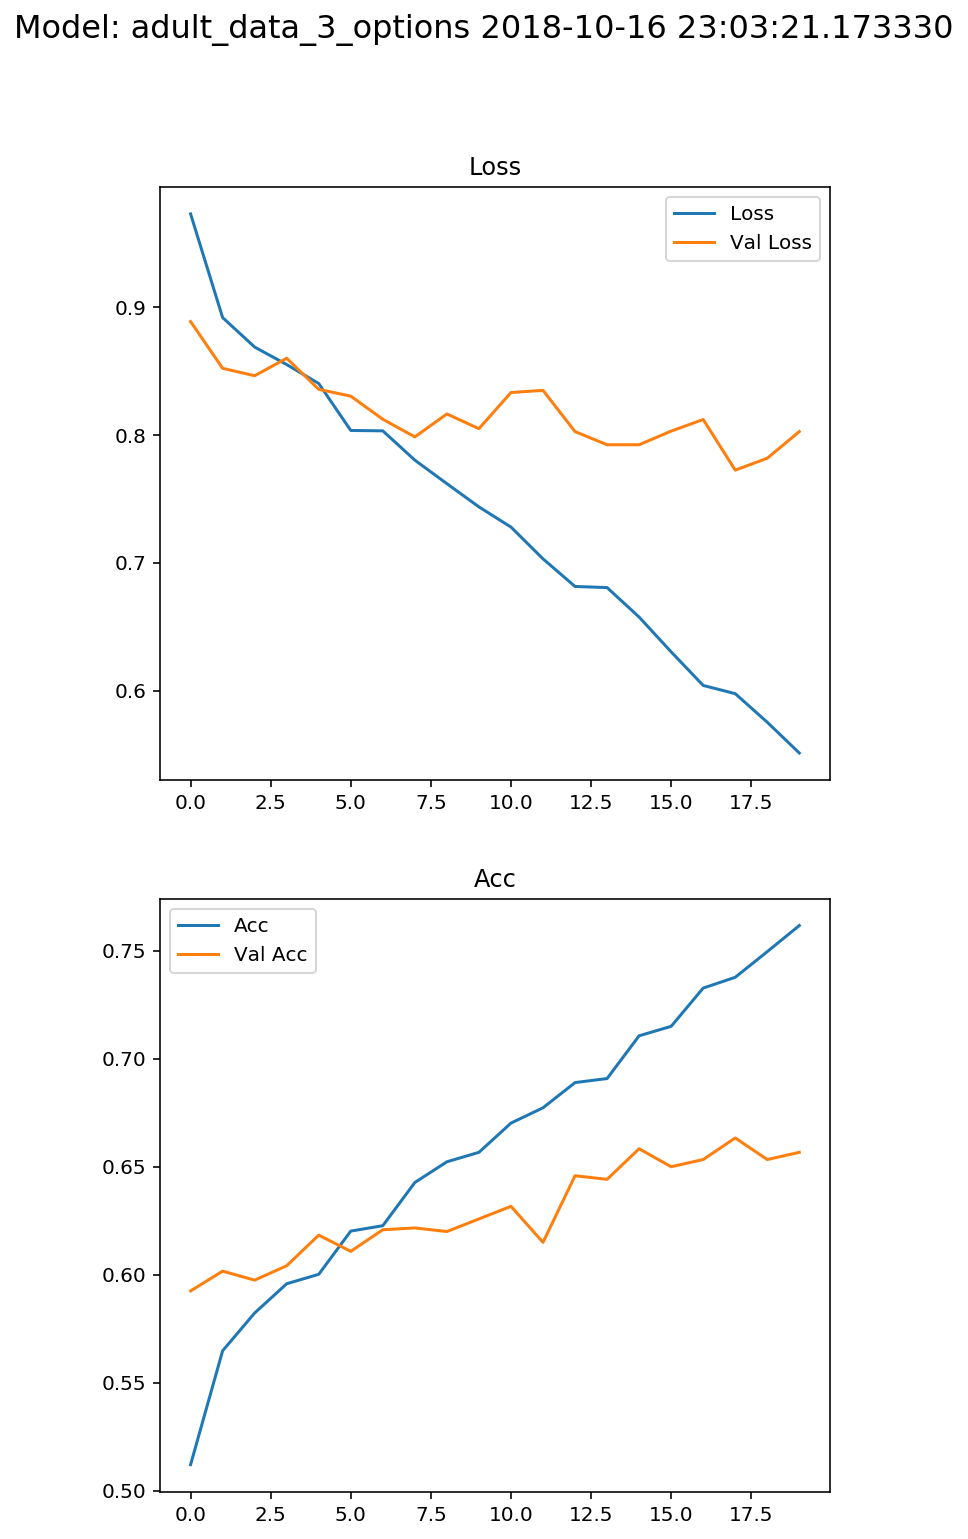

In [73]:
graph_size = 6
evaluate_model(test_model_history, most_recent_model_name, size=graph_size)


In [78]:
# This shows the different levels in my NN
test_model_history.model.get_config()

{'name': 'sequential_2',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 128, 128, 1),
    'dtype': 'float32',
    'filters': 6,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_3',
    'trainable': True,
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'clas

In [82]:
models[most_recent_model_name]['history'].model.predict(pic_df.drop(columns='class').iloc[1,:].values)

{'name': 'sequential_2',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 128, 128, 1),
    'dtype': 'float32',
    'filters': 6,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_3',
    'trainable': True,
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'clas

## Predicting
Creating predictions and getting useful, interpretable results from the models.

In [42]:
%%time

# Predicting on the images
X = pic_df.drop(columns='class')
pred_x = X.values.reshape(X.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
preds = test_model_real.predict(pred_x)

CPU times: user 4min 23s, sys: 13.4 s, total: 4min 36s
Wall time: 51.5 s


In [68]:
# Converting the target values to the 
y_real = pic_df['class']
y_real = y_real.map(lambda x: CURR_MAP[x])

In [69]:
#preds = pd.DataFrame(data=preds, columns=[])
new_preds = []
for i in range(len(preds)):
     new_preds.append(preds[i].argmax())
print(new_preds[0:20])

[0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 2, 2, 2, 1, 1, 0, 1, 1, 2]


In [71]:
# Print out the actual values against their predicted values
index = 0
for i in zip(y_real, new_preds):
    print(i)
    index+=1
    if index > 20:
        break

(0, 0)
(0, 0)
(0, 0)
(2, 2)
(1, 1)
(1, 1)
(0, 0)
(0, 0)
(1, 1)
(1, 1)
(0, 0)
(2, 2)
(2, 2)
(2, 2)
(1, 1)
(1, 1)
(0, 0)
(1, 1)
(1, 1)
(2, 2)
(1, 1)


## End Predicting

In [39]:
display(models)

{'../data/models/adult_data_3_options 2018-10-16 23:03:21.173330.h5': {'NUM_IMAGES': 6000,
  'history': <keras.callbacks.History at 0x7fd9a27b86a0>,
  'EPOCHS': 20,
  'IMAGE_SIZE': (128, 128),
  'Y_MAP': {'Lung Opacity': 1, 'No Lung Opacity / Not Normal': 0, 'Normal': 2},
  'TRAIN_SIZE': 0.8}}

In [ ]:
# Loading in the list of models/parameters

model_pickle_file_name = 'models.pk'
file_object = open(model_pickle_file_name,'r')

models = pickle.load(file_object)
file_object.close()

display(models)

# What am I trying to do now?
- start changing models around potentially using 
    - Stochastic gradient descent
    - [R-CNN (or a different iteration)](https://heartbeat.fritz.ai/the-5-computer-vision-techniques-that-will-change-how-you-see-the-world-1ee19334354b)
    - [SpatialDropout2D](https://keras.io/layers/core/#spatialdropout2d)


## Modeling over full adult set for 80 epochs

In [92]:
# Current Parameters
options = 3


NUM_IMAGES = pic_df.shape[0]
EPOCHS = 80
IMAGE_SIZE = (128,128)
TRAIN_SIZE = 0.8
METRICS = ['accuracy']

if options == 2:
    CURR_MAP = y_map_2
    model_name = 'adult_data_2_options'
elif options == 3:
    CURR_MAP = y_map_3
    model_name = 'adult_data_3_options'
else:
    raise PnemoniaTargetMapIsWeird('Set "option" to 2 or 3')


In [93]:
%%time

test_model_history, test_model_real, most_recent_model_name = model(pic_df.head(NUM_IMAGES), model_name = model_name, image_size=IMAGE_SIZE, y_map=CURR_MAP, EPOCHS=EPOCHS, train_size = TRAIN_SIZE, metrics = METRICS)



---Enter Function---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


---Modeling---
Train on 22029 samples, validate on 5508 samples
Epoch 1/80
22029/22029 [==============================] - 123s 6ms/step - loss: 0.8682 - acc: 0.5785 - val_loss: 0.8411 - val_acc: 0.5866
Epoch 3/80
22029/22029 [==============================] - 122s 6ms/step - loss: 0.8454 - acc: 0.5920 - val_loss: 0.8162 - val_acc: 0.6011
Epoch 4/80
22029/22029 [==============================] - 122s 6ms/step - loss: 0.8242 - acc: 0.6075 - val_loss: 0.8051 - val_acc: 0.6133
Epoch 5/80
22029/22029 [==============================] - 122s 6ms/step - loss: 0.8134 - acc: 0.6096 - val_loss: 0.7980 - val_acc: 0.6186
Epoch 6/80
 7776/22029 [=========>....................] - ETA: 1:13 - loss: 0.7967 - acc: 0.6191

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 122s 6ms/step - loss: 0.7814 - acc: 0.6320 - val_loss: 0.7924 - val_acc: 0.6182
Epoch 9/80
22029/22029 [==============================] - 122s 6ms/step - loss: 0.7708 - acc: 0.6382 - val_loss: 0.7703 - val_acc: 0.6224
Epoch 10/80
22029/22029 [==============================] - 122s 6ms/step - loss: 0.7598 - acc: 0.6465 - val_loss: 0.7671 - val_acc: 0.6224
Epoch 11/80
22029/22029 [==============================] - 123s 6ms/step - loss: 0.7526 - acc: 0.6456 - val_loss: 0.7707 - val_acc: 0.6304
Epoch 12/80
  288/22029 [..............................] - ETA: 1:50 - loss: 0.7904 - acc: 0.6389

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 124s 6ms/step - loss: 0.7400 - acc: 0.6560 - val_loss: 0.7557 - val_acc: 0.6365
Epoch 14/80
11744/22029 [==============>...............] - ETA: 53s - loss: 0.7433 - acc: 0.6545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 122s 6ms/step - loss: 0.7119 - acc: 0.6725 - val_loss: 0.7460 - val_acc: 0.6492
Epoch 18/80
22029/22029 [==============================] - 122s 6ms/step - loss: 0.7014 - acc: 0.6783 - val_loss: 0.7438 - val_acc: 0.6467
Epoch 19/80
22029/22029 [==============================] - 123s 6ms/step - loss: 0.6996 - acc: 0.6817 - val_loss: 0.7405 - val_acc: 0.6469
Epoch 20/80
22029/22029 [==============================] - 123s 6ms/step - loss: 0.6885 - acc: 0.6893 - val_loss: 0.7408 - val_acc: 0.6492
Epoch 21/80
 3712/22029 [====>.........................] - ETA: 1:34 - loss: 0.6691 - acc: 0.6945

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 123s 6ms/step - loss: 0.6743 - acc: 0.6976 - val_loss: 0.7369 - val_acc: 0.6523
Epoch 23/80
 7328/22029 [========>.....................] - ETA: 1:15 - loss: 0.6654 - acc: 0.7028

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 123s 6ms/step - loss: 0.6498 - acc: 0.7116 - val_loss: 0.7357 - val_acc: 0.6569
Epoch 27/80
22029/22029 [==============================] - 123s 6ms/step - loss: 0.6486 - acc: 0.7093 - val_loss: 0.7288 - val_acc: 0.6625
Epoch 28/80
22029/22029 [==============================] - 123s 6ms/step - loss: 0.6407 - acc: 0.7135 - val_loss: 0.7347 - val_acc: 0.6614
Epoch 29/80
20064/22029 [==========================>...] - ETA: 10s - loss: 0.6340 - acc: 0.7188

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 123s 6ms/step - loss: 0.6199 - acc: 0.7289 - val_loss: 0.7288 - val_acc: 0.6645
Epoch 32/80
 8032/22029 [=========>....................] - ETA: 1:12 - loss: 0.6229 - acc: 0.7251

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 123s 6ms/step - loss: 0.5960 - acc: 0.7352 - val_loss: 0.7286 - val_acc: 0.6676
Epoch 36/80
22029/22029 [==============================] - 123s 6ms/step - loss: 0.5927 - acc: 0.7400 - val_loss: 0.7241 - val_acc: 0.6652
Epoch 37/80
22029/22029 [==============================] - 125s 6ms/step - loss: 0.5866 - acc: 0.7445 - val_loss: 0.7230 - val_acc: 0.6649
Epoch 38/80
13600/22029 [=================>............] - ETA: 43s - loss: 0.5873 - acc: 0.7399

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 122s 6ms/step - loss: 0.5762 - acc: 0.7493 - val_loss: 0.7265 - val_acc: 0.6710
Epoch 41/80
 9024/22029 [===========>..................] - ETA: 1:06 - loss: 0.5675 - acc: 0.7534

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 125s 6ms/step - loss: 0.5561 - acc: 0.7594 - val_loss: 0.7282 - val_acc: 0.6734
Epoch 45/80
22029/22029 [==============================] - 124s 6ms/step - loss: 0.5475 - acc: 0.7623 - val_loss: 0.7345 - val_acc: 0.6785
Epoch 46/80
22029/22029 [==============================] - 125s 6ms/step - loss: 0.5434 - acc: 0.7684 - val_loss: 0.7241 - val_acc: 0.6877
Epoch 47/80
15136/22029 [===================>..........] - ETA: 35s - loss: 0.5369 - acc: 0.7713

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 125s 6ms/step - loss: 0.5325 - acc: 0.7742 - val_loss: 0.7297 - val_acc: 0.6837
Epoch 50/80
 2944/22029 [===>..........................] - ETA: 1:39 - loss: 0.5316 - acc: 0.7680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 125s 6ms/step - loss: 0.5130 - acc: 0.7831 - val_loss: 0.7506 - val_acc: 0.6687
Epoch 53/80
22029/22029 [==============================] - 127s 6ms/step - loss: 0.5133 - acc: 0.7802 - val_loss: 0.7293 - val_acc: 0.6718
Epoch 54/80
22029/22029 [==============================] - 123s 6ms/step - loss: 0.5112 - acc: 0.7816 - val_loss: 0.7229 - val_acc: 0.6783
Epoch 55/80
22029/22029 [==============================] - 124s 6ms/step - loss: 0.5169 - acc: 0.7802 - val_loss: 0.7389 - val_acc: 0.6750
Epoch 56/80
22029/22029 [==============================] - 126s 6ms/step - loss: 0.5064 - acc: 0.7849 - val_loss: 0.7189 - val_acc: 0.6772
Epoch 57/80
22029/22029 [==============================] - 125s 6ms/step - loss: 0.4968 - acc: 0.7919 - val_loss: 0.7110 - val_acc: 0.6837
Epoch 58/80
22029/22029 [==============================] - 126s 6ms/step - loss: 0.4933 - acc: 0.7934 - val_loss: 0.7181 - val_acc: 0.6870
Epoch 59/80
22029/22029 [==============

In [94]:
models[most_recent_model_name] = {
    'NUM_IMAGES':NUM_IMAGES,
    'history':test_model_history,
    'EPOCHS':EPOCHS,
    'IMAGE_SIZE':IMAGE_SIZE,
    'Y_MAP':CURR_MAP,
    'TRAIN_SIZE':TRAIN_SIZE,
    'accuracy_scores':{
        'train':test_model_history.history['acc'][-1],
        'test':test_model_history.history['val_acc'][-1]
    }
}

# Save the list of models and parameters 
model_pickle_file_name = 'models.pk'
file_object = open(model_pickle_file_name,'wb')
pickle.dump(models, file_object)
file_object.close()


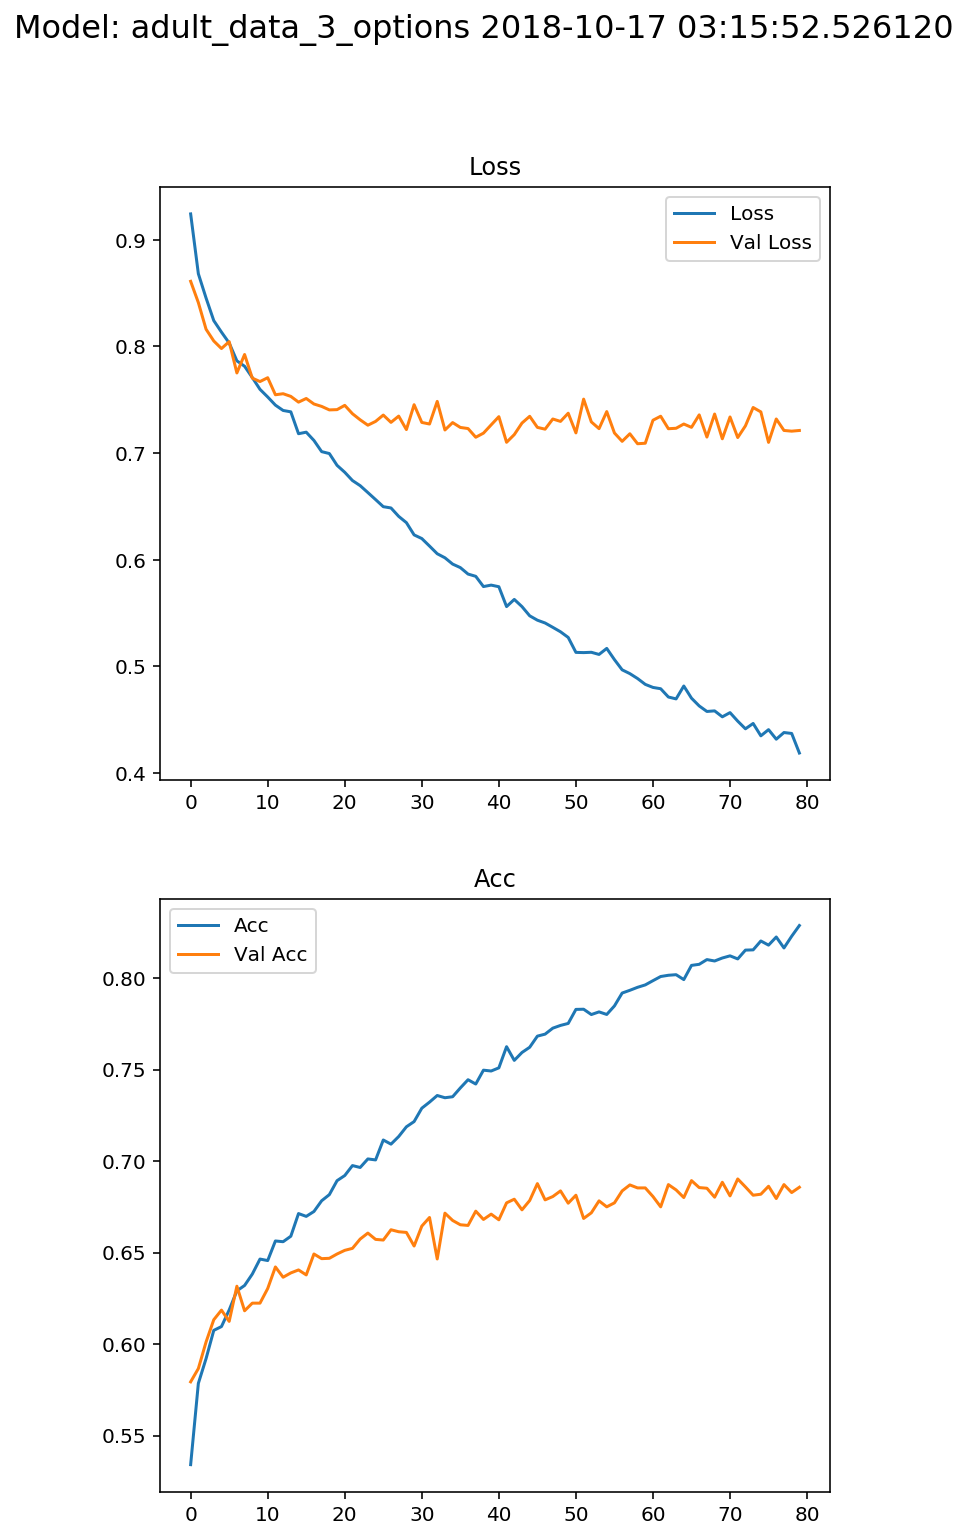

In [95]:
graph_size = 6
evaluate_model(test_model_history, most_recent_model_name, size=graph_size)
